## Libs

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import quantstats as qs
## plots
import matplotlib.pyplot as plt
import seaborn as sns

## Settings

In [2]:
## plot settings
%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

## supress future warns
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
#warnings.simplefilter(action="ignore")


## Download FAANG stocks

[*********************100%%**********************]  5 of 5 completed


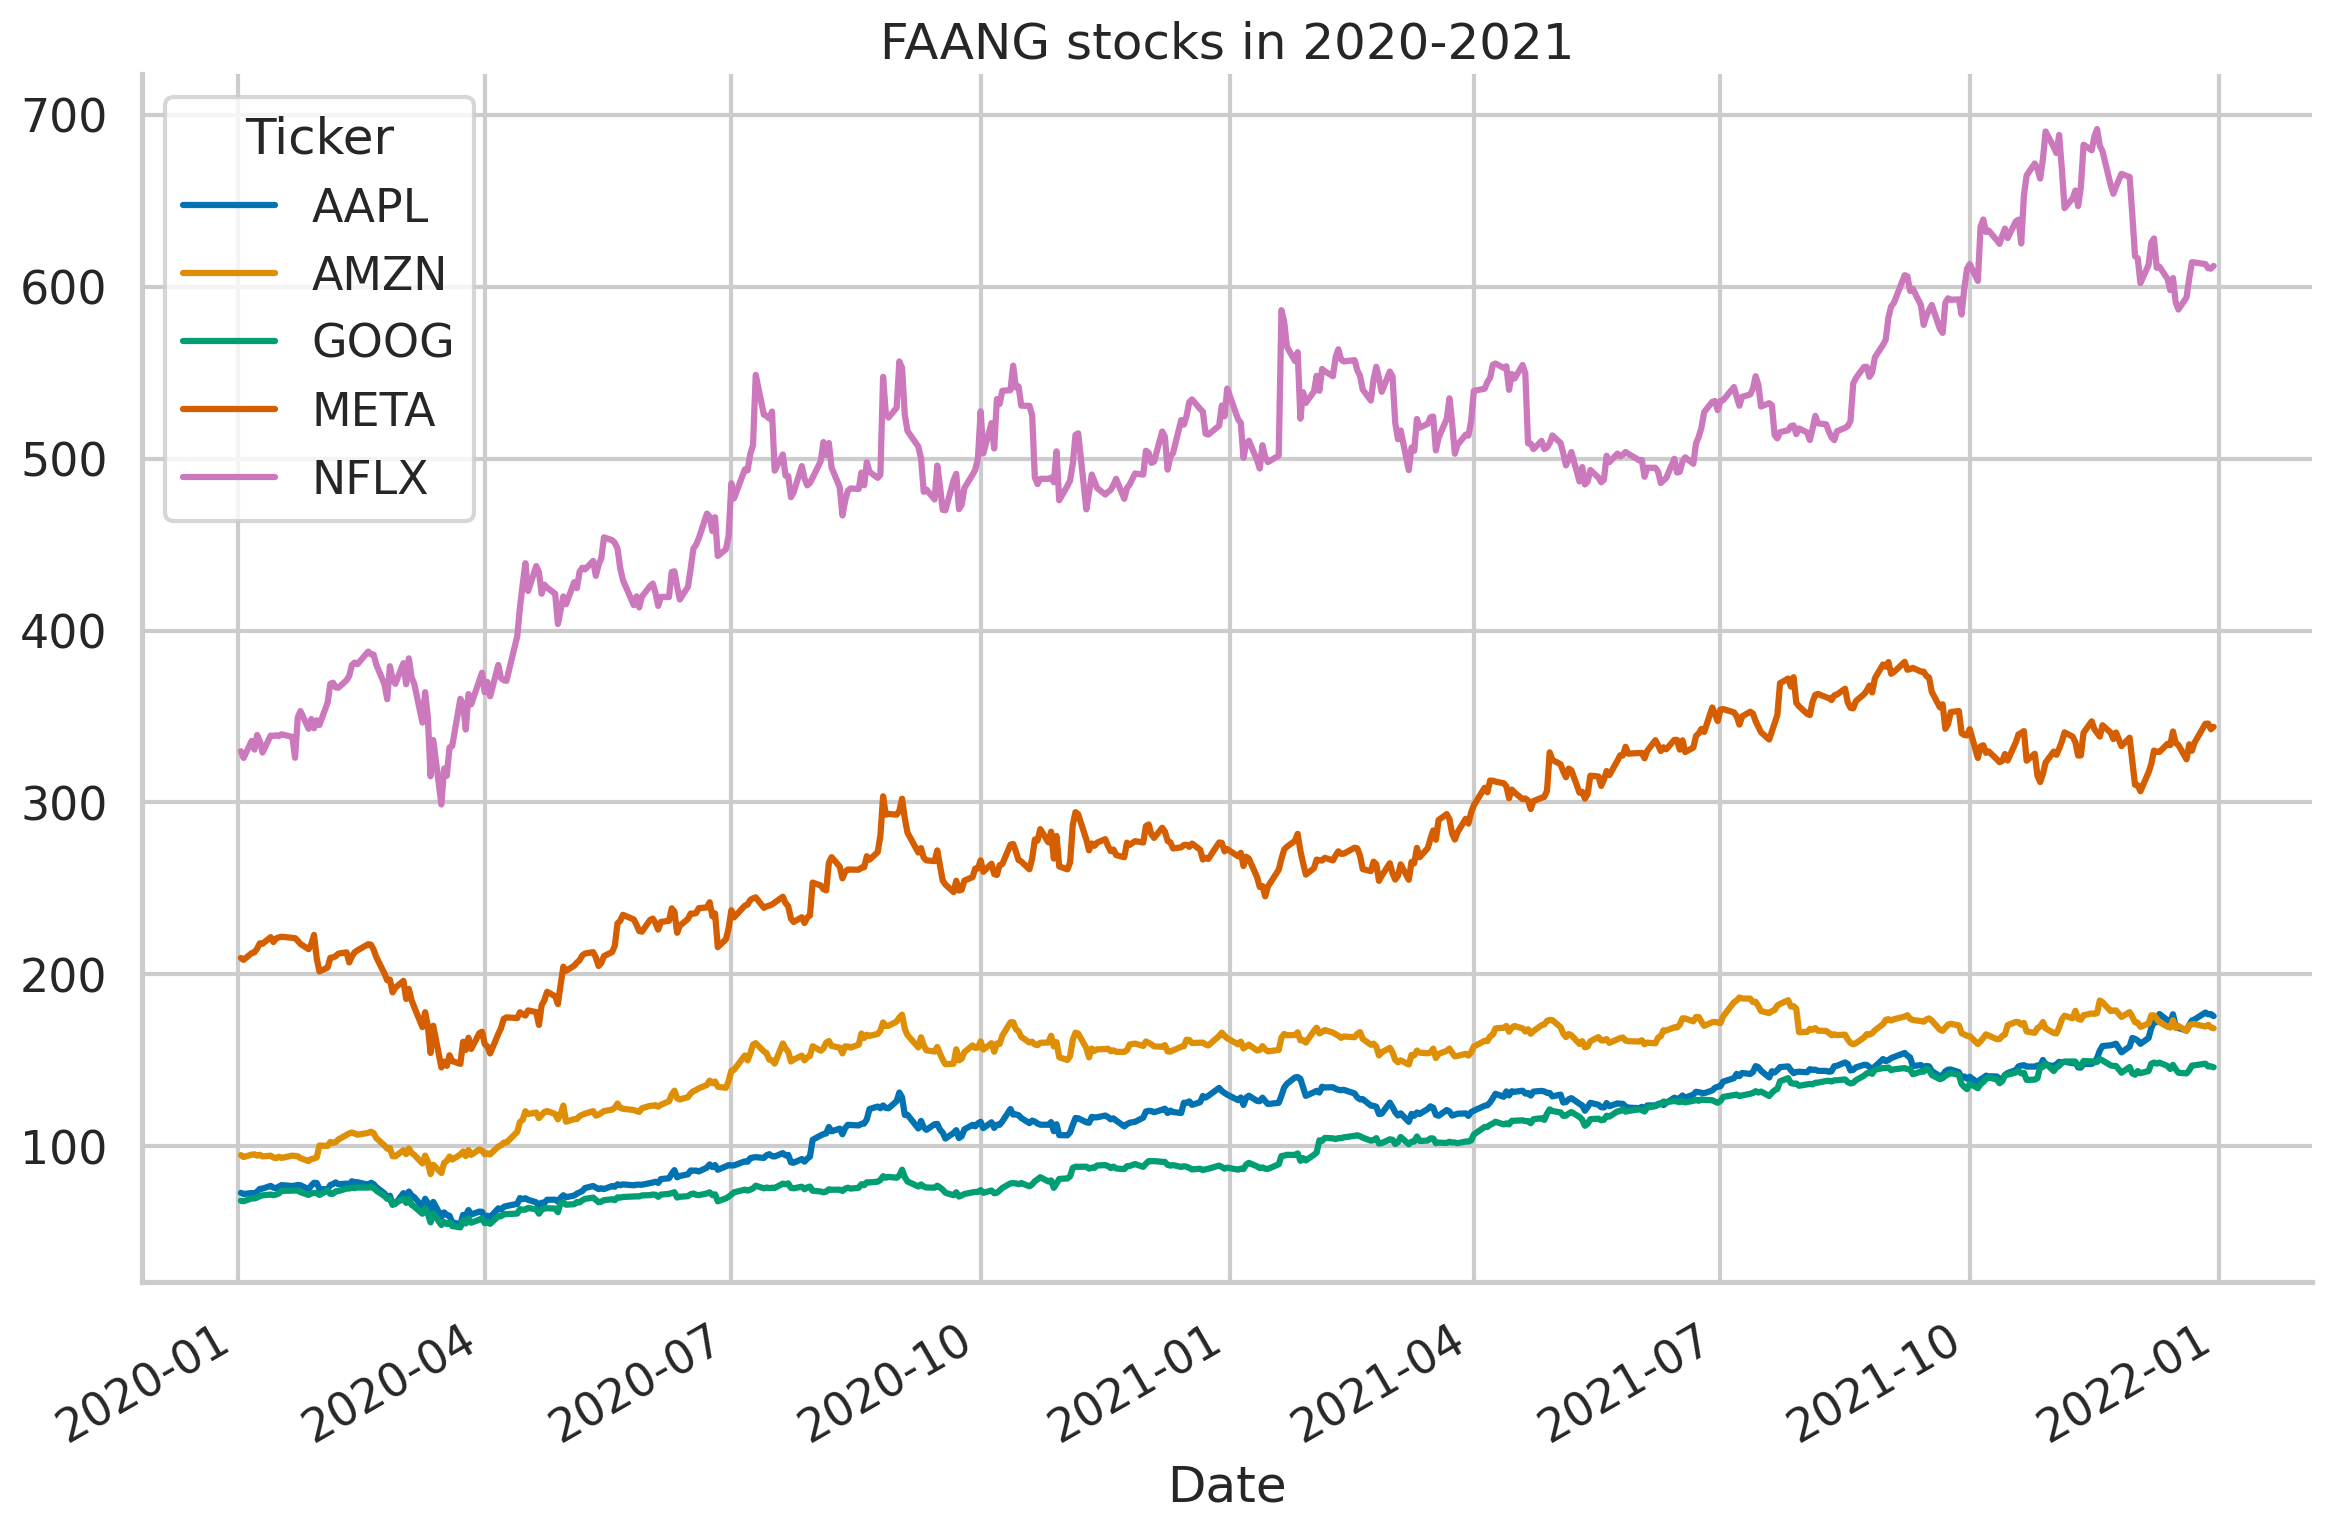

In [3]:
ASSETS = ["META", "AMZN", "AAPL", "NFLX", "GOOG"]
ASSETS.sort()
n_assets = len(ASSETS)
START_DATE = "2020-01-01"
END_DATE = "2021-12-31"
prices_df = yf.download(ASSETS, 
                        start=START_DATE, 
                        end=END_DATE)
prices_df["Adj Close"].plot(title="FAANG stocks in 2020-2021")

sns.despine()
plt.tight_layout()

## Create a portfolio with equal weights

In [4]:
returns = prices_df["Adj Close"].pct_change().dropna()
portfolio_weights = n_assets * [1 / n_assets]

### Calculate portfolio's performance

In [5]:
portfolio_returns = pd.Series(
    np.dot(portfolio_weights, returns.T), 
    index=returns.index
)

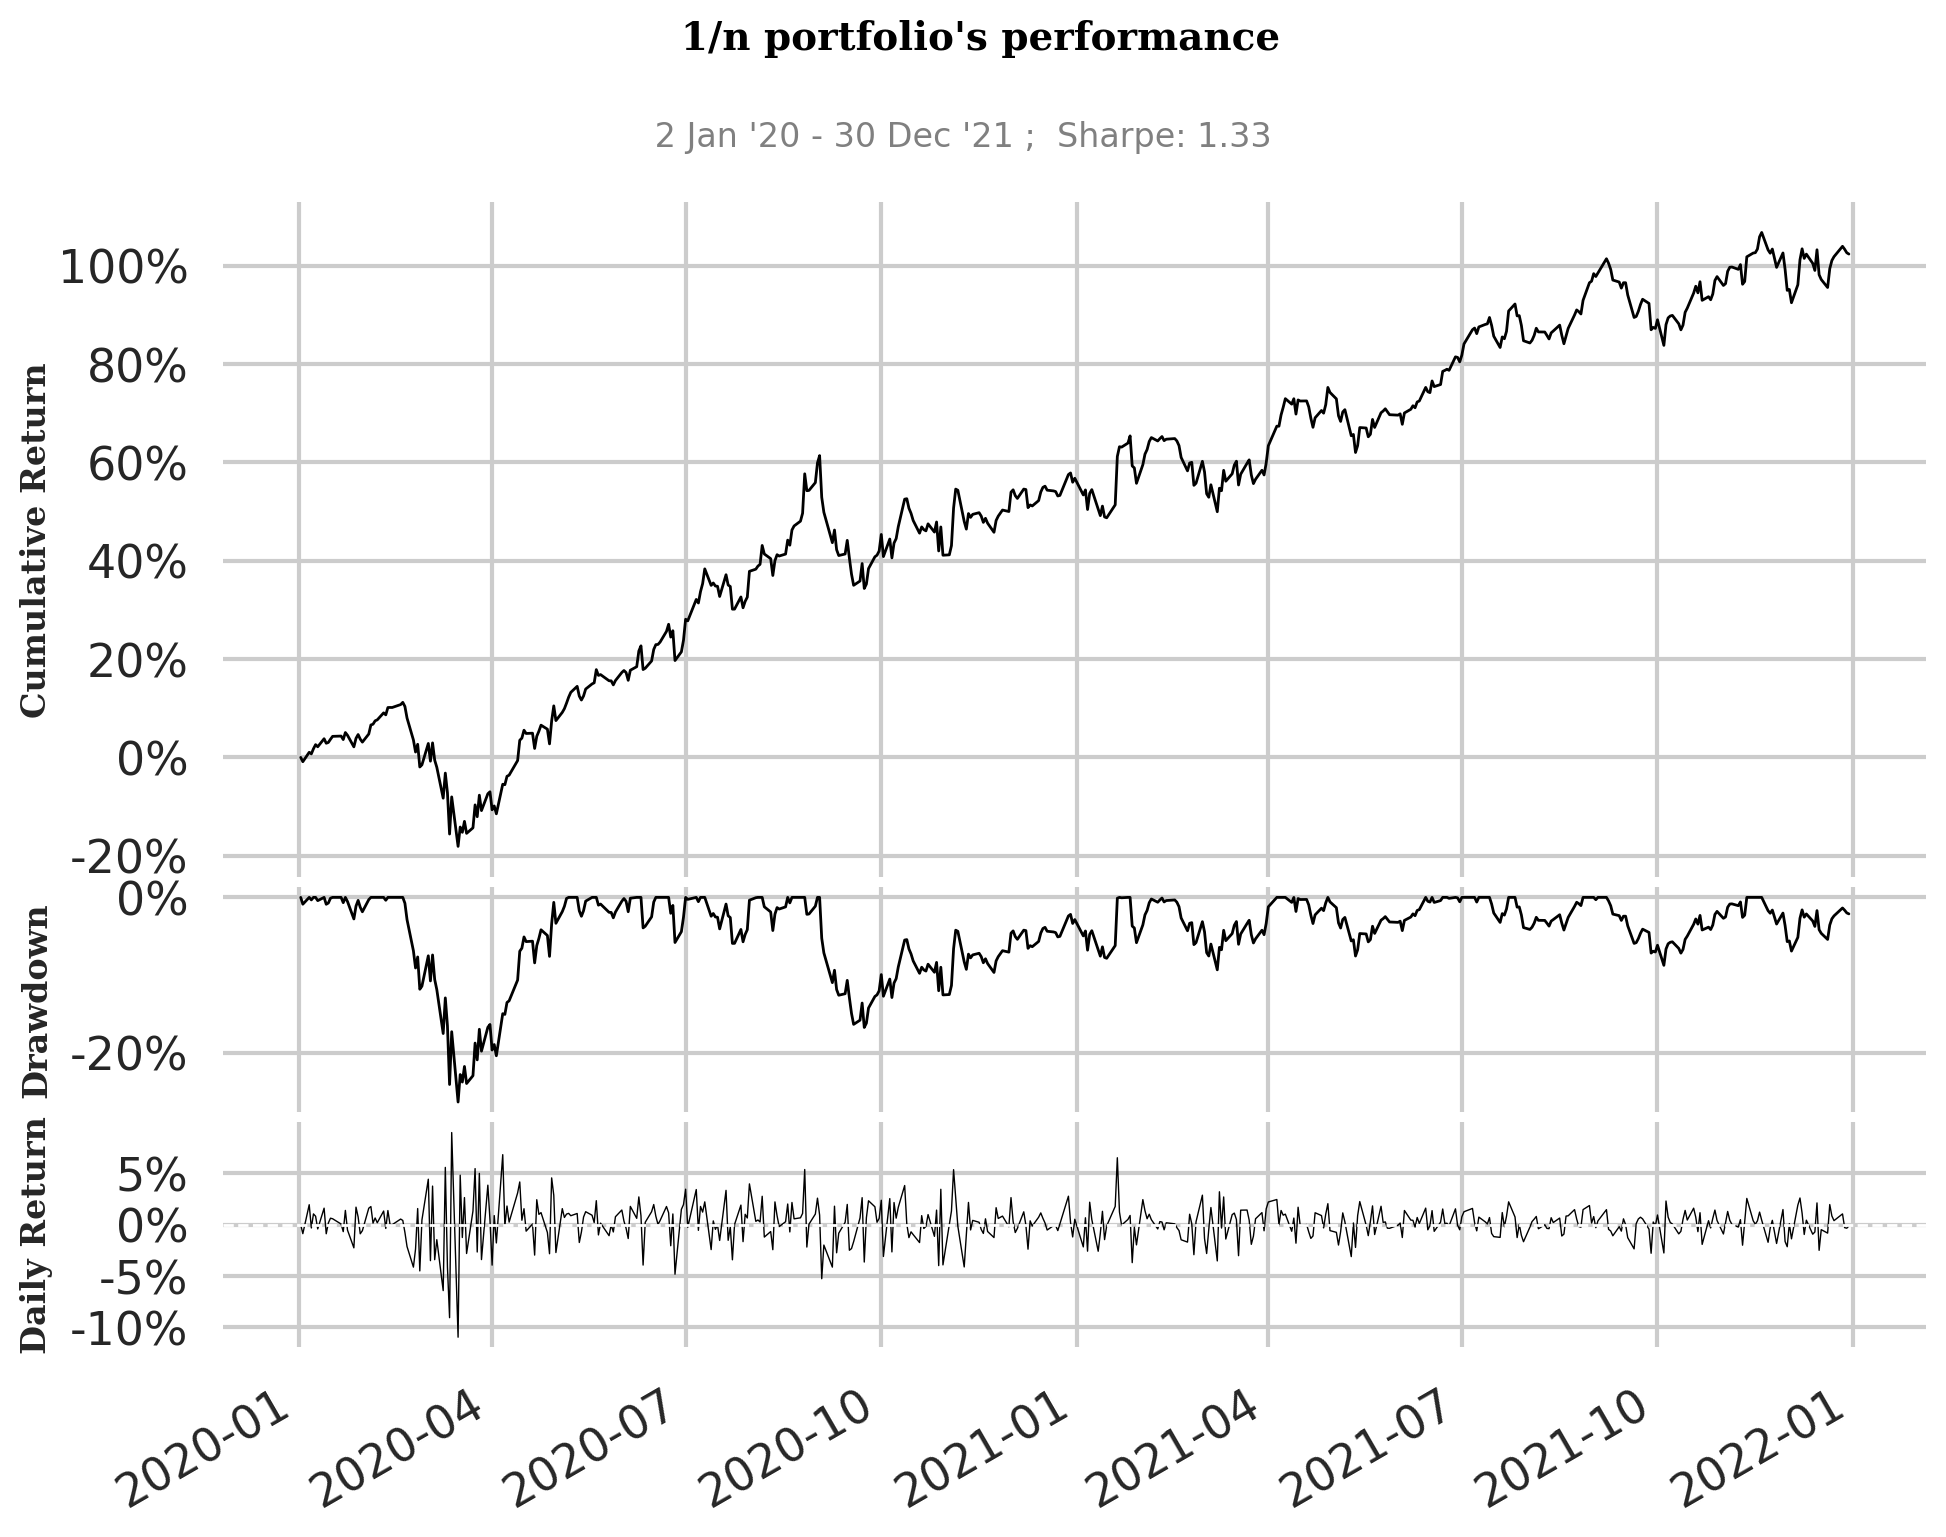

In [6]:
qs.plots.snapshot(portfolio_returns, 
                  title="1/n portfolio's performance", 
                  grayscale=True,
                  fontname='serif'
                 )

### Look at portfolio evaluation metrics

In [7]:
qs.reports.metrics(portfolio_returns, 
                   benchmark="SPY", 
                   mode="basic")

[*********************100%%**********************]  1 of 1 completed

                    Benchmark (SPY)    Strategy
------------------  -----------------  ----------
Start Period        2020-01-03         2020-01-03
End Period          2021-12-30         2021-12-30
Risk-Free Rate      0.0%               0.0%
Time in Market      100.0%             100.0%

Cumulative Return   47.69%             104.18%
CAGR﹪              14.47%             28.07%

Sharpe              0.9                1.34
Prob. Sharpe Ratio  89.13%             96.83%
Sortino             1.23               1.93
Sortino/√2          0.87               1.36
Omega               1.27               1.27

Max Drawdown        -34.1%             -26.35%
Longest DD Days     180                140

Gain/Pain Ratio     0.2                0.27
Gain/Pain (1M)      1.44               3.42

Payoff Ratio        0.79               0.84
Profit Factor       1.2                1.27
Common Sense Ratio  0.96               1.2
CPC Index           0.55               0.63
Tail Ratio          0.8                0

## Efficient frontier using Monte Carlo

In [8]:
## params
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252

<Axes: title={'center': "Daily returns of the selected companies' stocks"}, xlabel='Date'>

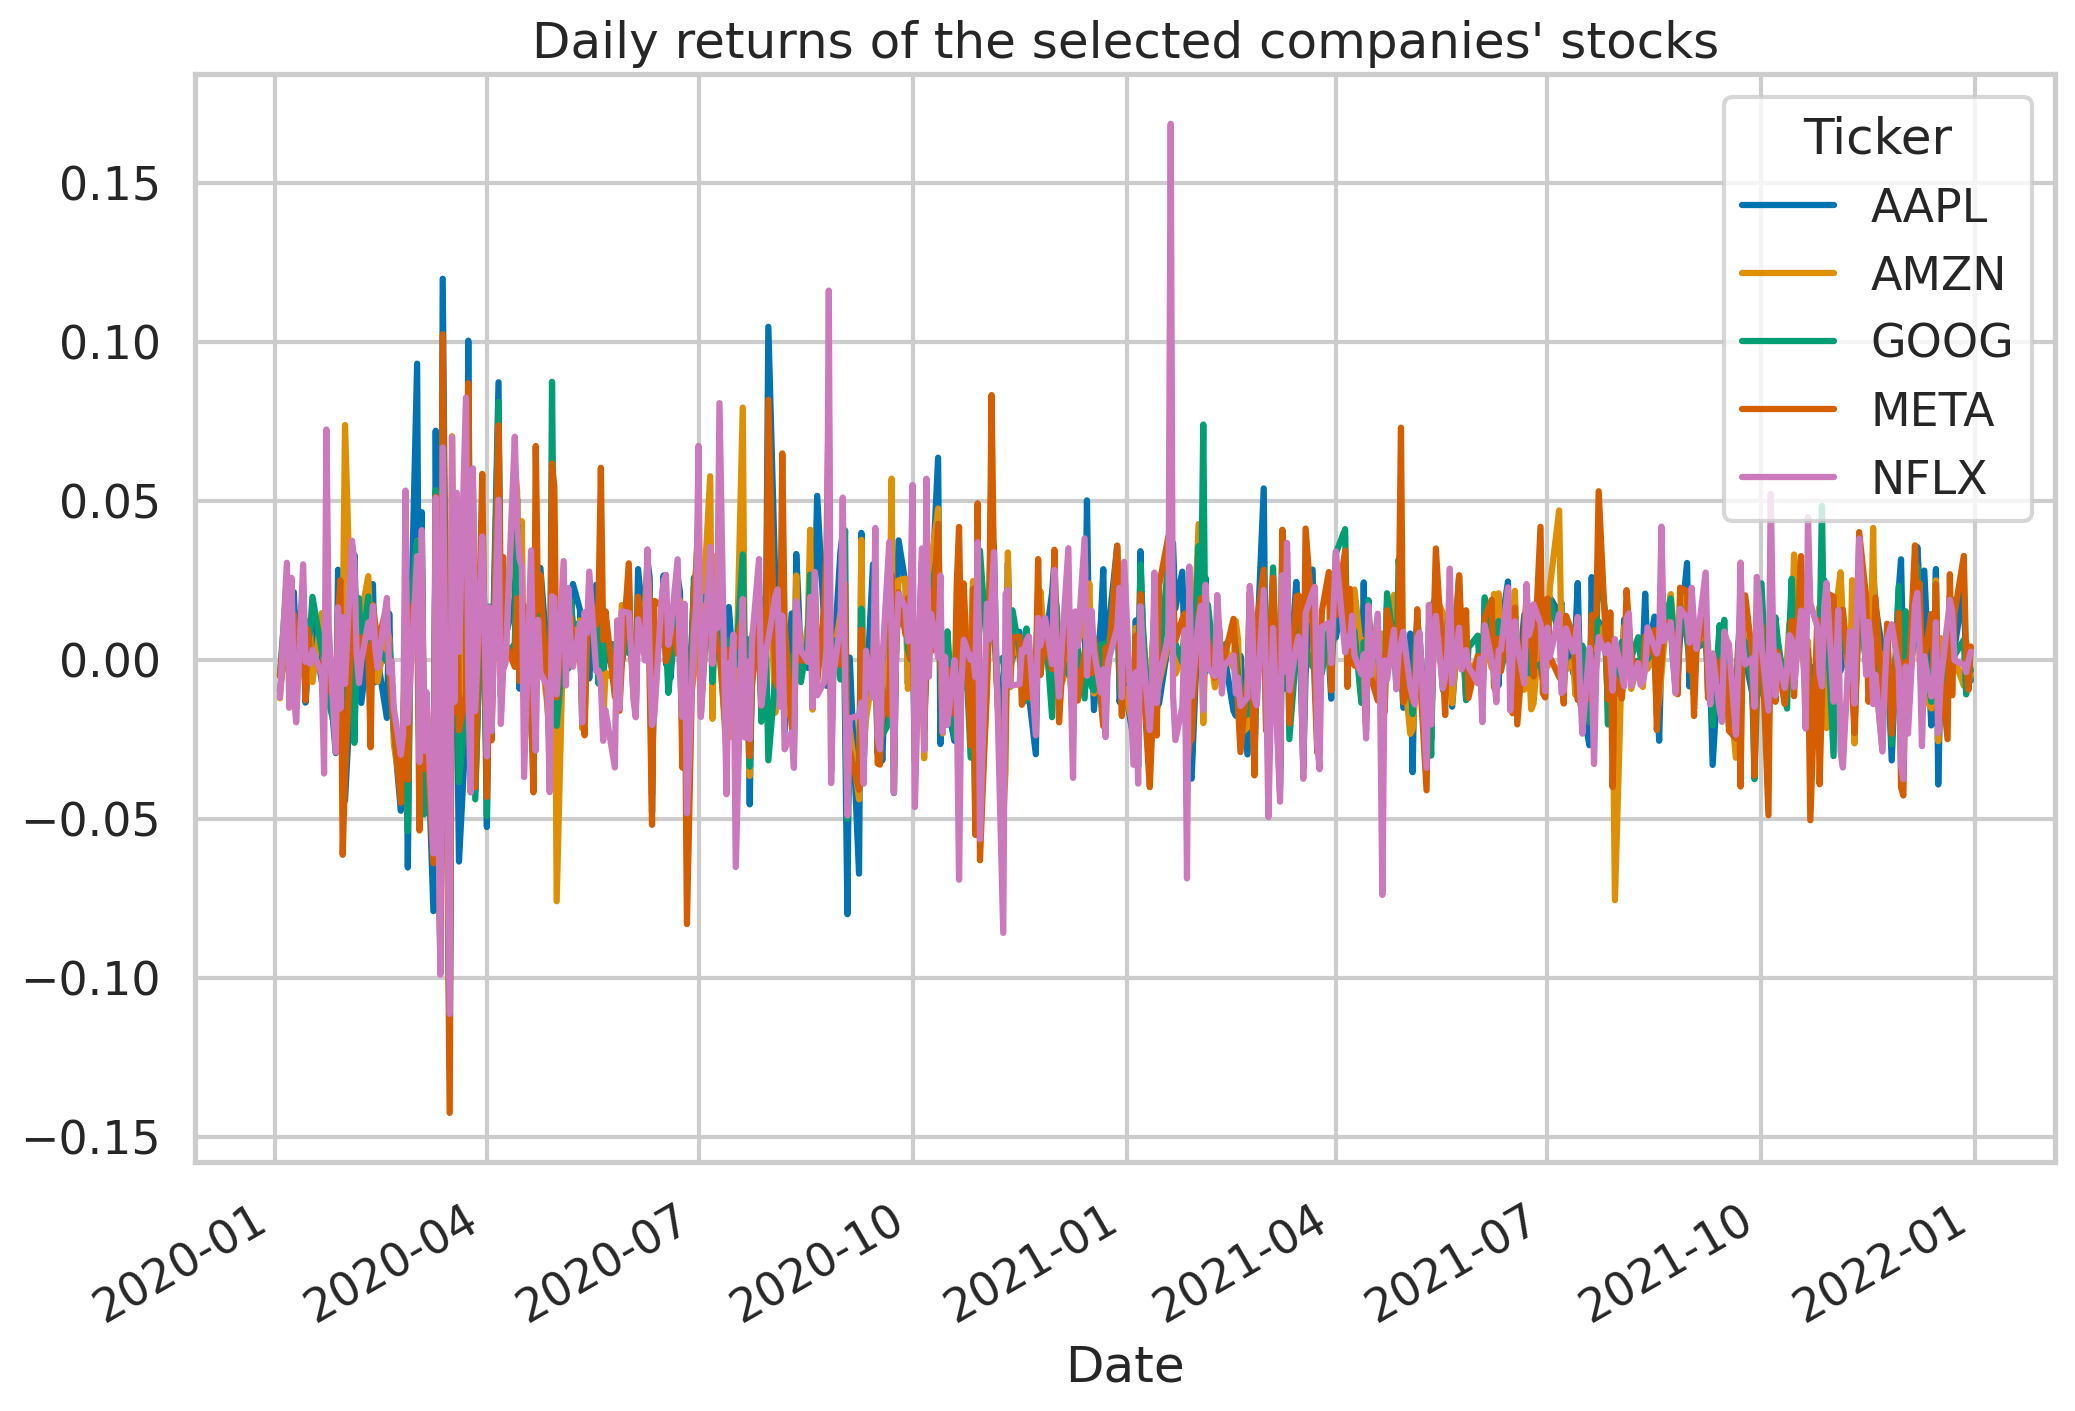

In [9]:
returns_df = prices_df["Adj Close"].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS
returns_df.plot(title="Daily returns of the selected companies' stocks")

In [10]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

### Volatility and Sharpe ratio 

In [11]:
portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    vol = np.sqrt(
        np.dot(weights[i].T, np.dot(cov_mat, weights[i]))
    )
    portf_vol.append(vol)
portf_vol = np.array(portf_vol)  

portf_sharpe_ratio = portf_rtns / portf_vol

In [12]:
portf_results_df = pd.DataFrame(
    {"returns": portf_rtns,
     "volatility": portf_vol,
     "sharpe_ratio": portf_sharpe_ratio}
)
portf_results_df

,returns,volatility,sharpe_ratio
0,0.385483,0.296911,1.298310
1,0.394279,0.305556,1.290366
2,0.378046,0.289732,1.304811
3,0.389480,0.299091,1.302215
4,0.418818,0.310084,1.350659
...,...,...,...
99995,0.397440,0.296396,1.340909
99996,0.383703,0.292634,1.311205
99997,0.400238,0.303984,1.316642
99998,0.378714,0.299872,1.262921


### Create efficient frontier

In [13]:
N_POINTS = 100

ef_rtn_list = []
ef_vol_list = []

possible_ef_rtns = np.linspace(
    portf_results_df["returns"].min(), 
    portf_results_df["returns"].max(), 
    N_POINTS
)
possible_ef_rtns = np.round(possible_ef_rtns, 2)    
portf_rtns = np.round(portf_rtns, 2)

for rtn in possible_ef_rtns:
    if rtn in portf_rtns:
        ef_rtn_list.append(rtn)
        matched_ind = np.where(portf_rtns == rtn)
        ef_vol_list.append(np.min(portf_vol[matched_ind]))

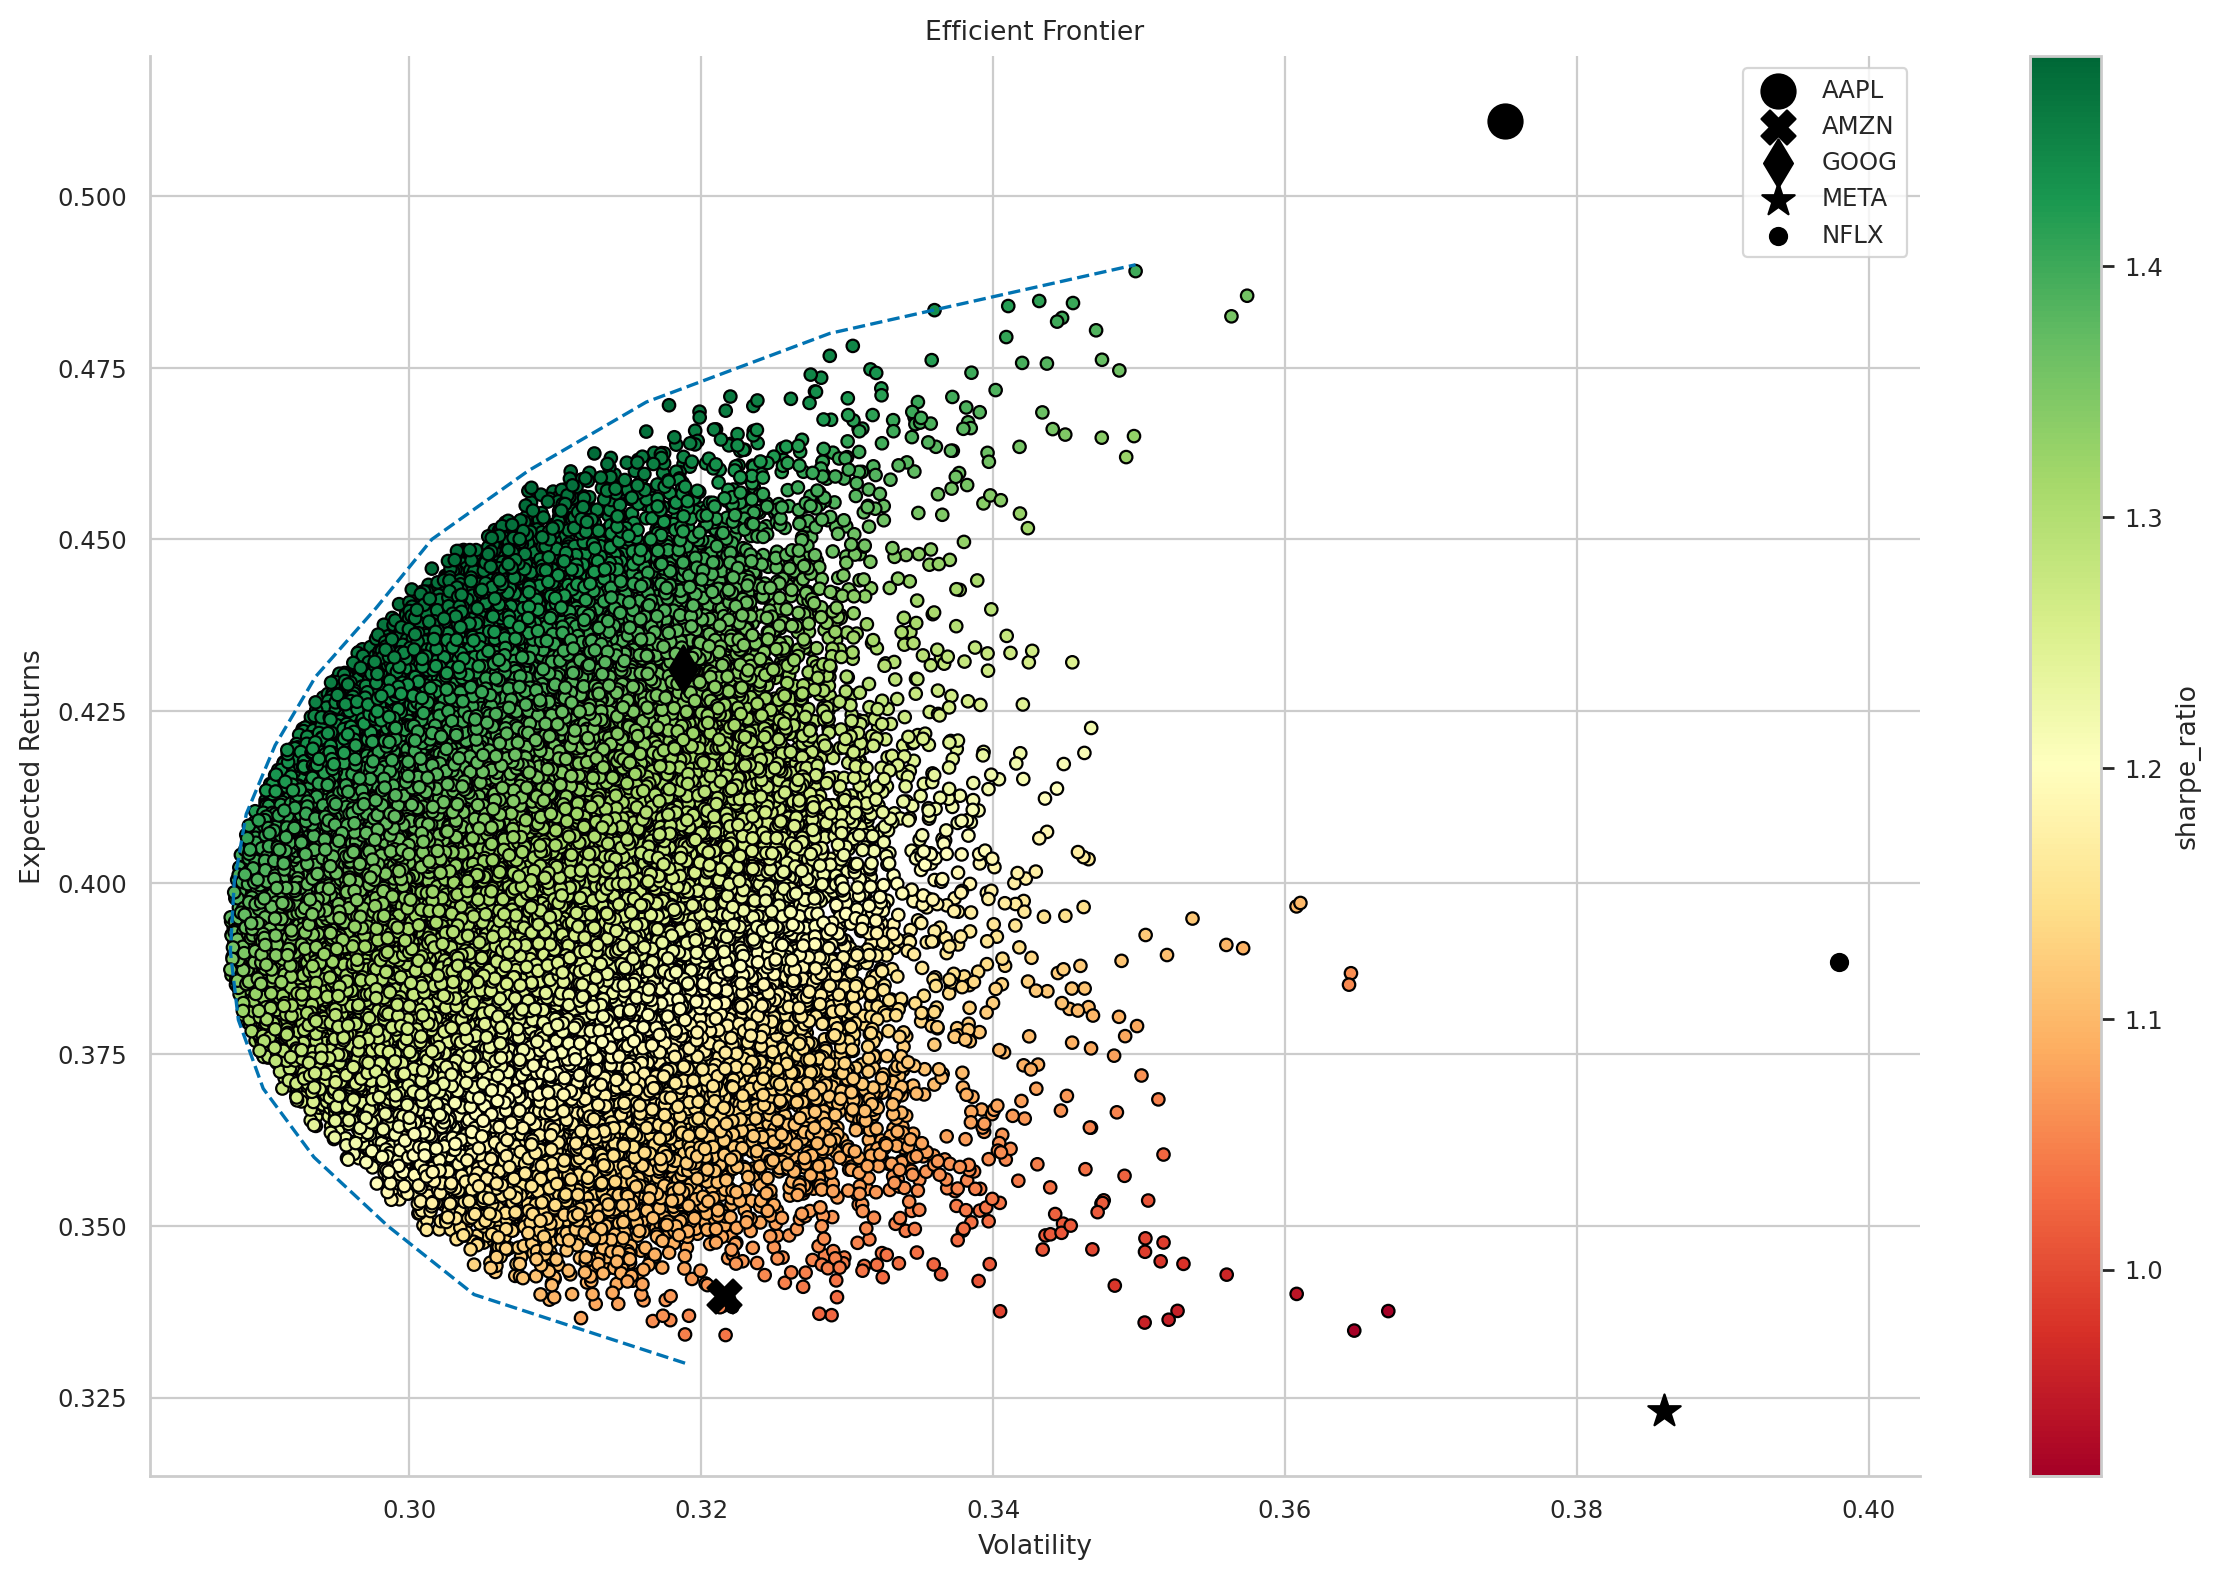

In [14]:
MARKERS = ["o", "X", "d", "*","."]

with sns.plotting_context("paper"):
    fig, ax = plt.subplots()
    portf_results_df.plot(kind="scatter", x="volatility", 
                          y="returns", c="sharpe_ratio",
                          cmap="RdYlGn", edgecolors="black", 
                          ax=ax)
    ax.set(xlabel="Volatility", 
           ylabel="Expected Returns", 
           title="Efficient Frontier")
    ax.plot(ef_vol_list, ef_rtn_list, "b--")
    for asset_index in range(n_assets):
        ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                   y=avg_returns[asset_index], 
                   marker=MARKERS[asset_index], 
                   s=150, color="black",
                   label=ASSETS[asset_index])
    ax.legend()

    sns.despine()
    plt.tight_layout()

## Calculate value at risk (VaR)

In [15]:
## calculate covariance matrix
cov_mat = returns_df.corr()
print(cov_mat)

Ticker      AAPL      AMZN      GOOG      META      NFLX
Ticker                                                  
AAPL    1.000000  0.670217  0.698336  0.697754  0.514354
AMZN    0.670217  1.000000  0.652064  0.632580  0.610099
GOOG    0.698336  0.652064  1.000000  0.736279  0.504565
META    0.697754  0.632580  0.736279  1.000000  0.523555
NFLX    0.514354  0.610099  0.504565  0.523555  1.000000


### Cholesky decomposition of the covariance matrix

In [16]:
chol_mat = np.linalg.cholesky(cov_mat)
print(chol_mat)

[[1.         0.         0.         0.         0.        ]
 [0.67021695 0.74216524 0.         0.         0.        ]
 [0.6983356  0.24795991 0.67144864 0.         0.        ]
 [0.69775443 0.22223187 0.28879047 0.61672669 0.        ]
 [0.51435371 0.35756266 0.08446248 0.09859922 0.76859189]]


### Perform a Monte Carlo simulation

In [17]:
## constants
T = 1 # T day ahead
N_SIMS = 10 ** 5
SHARES = [5]*5

In [18]:
## drawing random numbers from Standard Normal distribution
np.random.seed(42)
rv = np.random.normal(size=(N_SIMS, len(ASSETS)))
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))
r = np.mean(returns_df, axis=0).values
sigma = np.std(returns_df, axis=0).values

In [19]:
## find initial value for log norm dist.
S_0 = prices_df["Adj Close"].values[-1, :]
P_0 = np.sum(SHARES * S_0)

In [20]:
## estimate the final price of stocks
S_T = S_0 * np.exp(
    (r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * correlated_rv
)

### Calculate VaR

In [21]:
P_T = np.sum(SHARES * S_T, axis=1)
P_diff = P_T - P_0
P_diff_sorted = np.sort(P_diff)
percentiles = [0.01, 0.1, 1.]
var = np.percentile(P_diff_sorted, percentiles)

for x, y in zip(percentiles, var):
    print(f"1-day VaR with {100-x}% confidence: {-y:.2f}$")

1-day VaR with 99.99% confidence: 495.54$
1-day VaR with 99.9% confidence: 419.88$
1-day VaR with 99.0% confidence: 317.16$


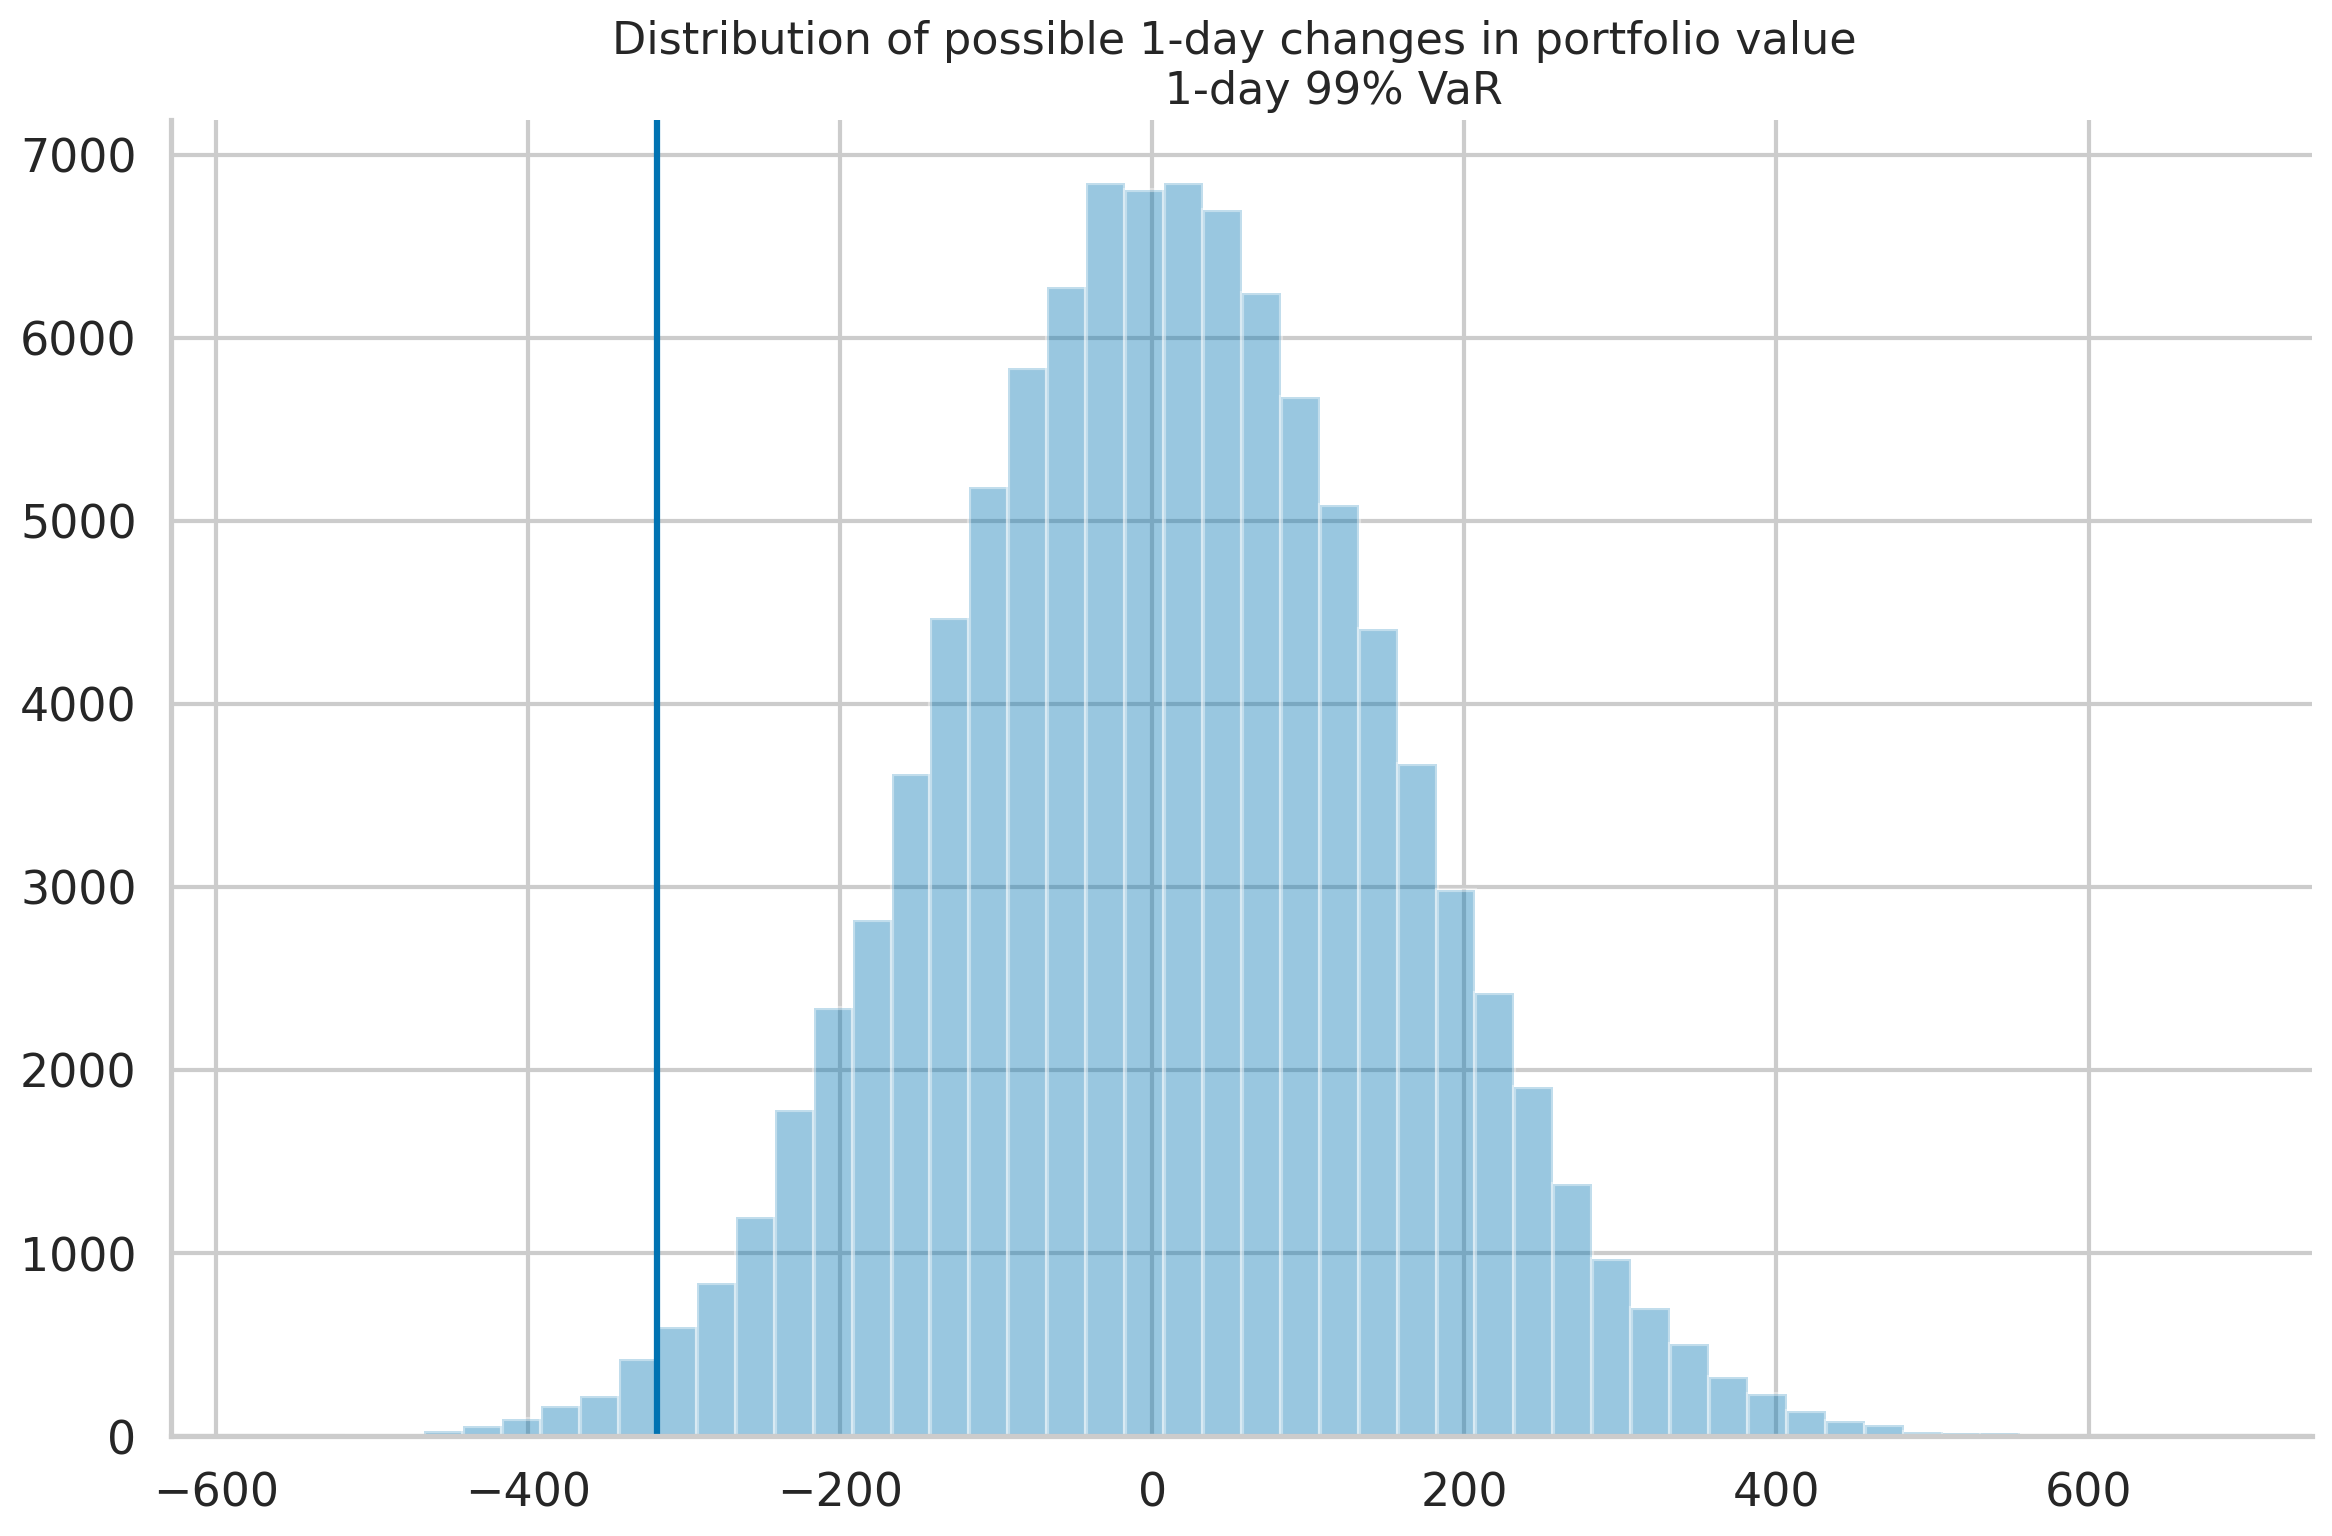

In [22]:
ax = sns.distplot(P_diff, kde=False)
ax.set_title("""Distribution of possible 1-day changes in portfolio value 
             1-day 99% VaR""", fontsize=16)
ax.axvline(var[2], 0, 10000)

sns.despine()
plt.tight_layout()

In [23]:
var = np.percentile(P_diff_sorted, 5)
expected_shortfall = P_diff_sorted[P_diff_sorted<=var].mean()

print(f'The 1-day 95% VaR is {-var:.2f}$, and the accompanying Expected Shortfall is {-expected_shortfall:.2f}$.')

The 1-day 95% VaR is 222.22$, and the accompanying Expected Shortfall is 279.70$.
